In [42]:
from __future__ import print_function
import sys
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)

from util.load_data import JSONData

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)

# Extracted Feature Analysis
An in depth evaluation of our accumulated feature sets.

Source of Methodology: 
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models/notebook
* http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

In [2]:
# Program Parameters
FEATURE_DIR = '../Data/train_feat/'
DATA_ROOT = '../Data/dataset/'

In [3]:
# Load Dataset
data = pd.read_csv(FEATURE_DIR+'feat.csv', sep=',', header=None).astype(float)

# Perform Pre-Filter to Remove Some Erraneous Records
data = data.replace([np.inf, -np.inf, np.nan], 0)

In [4]:
# Load Original Raw Dataset
data_load = JSONData(DATA_ROOT+'instances_train.jsonl', DATA_ROOT+'truth_train.jsonl', DATA_ROOT+'instances_test.jsonl')
train_Y = data_load.load_train_Y()

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,5.0,9.3,4.76,16.0,0.06,1.4,3399.0,10.03,8.28,...,0.0,0.0,1.0,0.0,87.0,87.0,86.0,85.0,84.0,83.0
1,1.0,0.0,9.2,5.28,11.0,0.09,1.5,364.0,12.16,10.36,...,0.0,0.0,0.0,0.0,47.0,47.0,46.0,45.0,44.0,43.0
2,2.0,0.0,10.2,4.94,16.0,0.06,1.5,3403.0,11.08,8.39,...,0.0,0.0,0.0,0.0,57.0,57.0,56.0,55.0,54.0,53.0
3,3.0,1.0,14.1,5.14,22.0,0.04,1.5,8962.0,12.83,8.59,...,0.0,0.0,0.0,0.0,52.0,52.0,51.0,50.0,49.0,48.0
4,4.0,2.0,10.5,4.91,17.0,0.06,1.5,4780.0,10.90,7.79,...,0.0,0.0,0.0,0.0,29.0,29.0,28.0,27.0,26.0,25.0


In [6]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
count,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,...,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000,17597.000000
mean,8790.645565,1.738876,12.266688,5.051408,19.131386,0.055641,1.494760,2972.949139,11.932927,8.703137,...,0.355174,0.306075,0.372677,0.193385,68.112803,68.112803,67.117975,66.123146,65.128317,64.133489
std,5074.983056,4.928167,7.354970,1.432511,7.297872,0.026430,0.350143,3506.999586,7.918858,1.274871,...,3.453867,3.390675,3.353602,3.252213,126.970278,126.970278,126.967524,126.964810,126.962137,126.959505
min,0.000000,0.000000,-2.300000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4396.000000,0.000000,10.100000,4.820000,16.000000,0.040000,1.400000,1183.000000,10.490000,8.110000,...,0.000000,0.000000,0.000000,0.000000,47.000000,47.000000,46.000000,45.000000,44.000000,43.000000
50%,8791.000000,1.000000,12.000000,5.020000,19.000000,0.050000,1.500000,2160.000000,11.770000,8.700000,...,0.000000,0.000000,0.000000,0.000000,57.000000,57.000000,56.000000,55.000000,54.000000,53.000000
75%,13185.000000,2.000000,13.800000,5.220000,22.000000,0.060000,1.600000,3790.000000,12.940000,9.280000,...,0.000000,0.000000,0.000000,0.000000,68.000000,68.000000,67.000000,66.000000,65.000000,64.000000
max,17580.000000,126.000000,213.700000,49.500000,396.000000,1.000000,11.900000,164319.000000,263.900000,28.860000,...,141.000000,140.000000,139.000000,138.000000,3388.000000,3388.000000,3387.000000,3386.000000,3385.000000,3384.000000


In [7]:
# Feature NULL Type Analysis
# Looks like our preprocessing routine screwed up big time with the n-gram based features.
print(data.isnull().any().values)

# Type for Each Feature Seems to be Correct
print(data.dtypes.values)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
[dtype('float64') dtype('float64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64') dtype('float64')
 dtype('float64') dtype('float64') dtype('float64') dty

In [8]:
# Drop First ID Col and Reindex Header
data = data.drop(data.columns[[0]],axis=1)
data.columns = range(len(data.columns))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,5.0,9.3,4.76,16.0,0.06,1.4,3399.0,10.03,8.28,174.0,...,0.0,0.0,1.0,0.0,87.0,87.0,86.0,85.0,84.0,83.0
1,0.0,9.2,5.28,11.0,0.09,1.5,364.0,12.16,10.36,27.0,...,0.0,0.0,0.0,0.0,47.0,47.0,46.0,45.0,44.0,43.0
2,0.0,10.2,4.94,16.0,0.06,1.5,3403.0,11.08,8.39,173.0,...,0.0,0.0,0.0,0.0,57.0,57.0,56.0,55.0,54.0,53.0
3,1.0,14.1,5.14,22.0,0.04,1.5,8962.0,12.83,8.59,426.0,...,0.0,0.0,0.0,0.0,52.0,52.0,51.0,50.0,49.0,48.0
4,2.0,10.5,4.91,17.0,0.06,1.5,4780.0,10.90,7.79,204.0,...,0.0,0.0,0.0,0.0,29.0,29.0,28.0,27.0,26.0,25.0


### Feature-Target Correlation Evaluation

In [9]:
# Extract Values
Y_target = np.array(map(lambda x: 0 if x['truthClass'] == 'no-clickbait' else 1, train_Y))
Y_mean = np.array(map(lambda x: x['truthMean'], train_Y))
Y_mod = np.array(map(lambda x: x['truthMode'], train_Y))
Y_var = np.array(map(lambda x: np.var(x['truthJudgments']), train_Y))
Y_id = map(lambda x: int(x['id']), train_Y)

# Filter Out Data Frame By Index
f_data = data.iloc[Y_id, :]

In [80]:
# Feature to Mean Correlation
sorted(zip(range(119), map(lambda i: np.corrcoef(f_data[i].values, Y_mean)[0][1]**2, range(119))), key=lambda tup: tup[1], reverse=True)

[(14, 0.0012895309499968205),
 (19, 0.0012081021866539492),
 (47, 0.0010348363234310666),
 (8, 0.00084168343037239178),
 (73, 0.00072065485901670373),
 (76, 0.00069458537296868638),
 (79, 0.00067115963440641158),
 (3, 0.00067046242854472209),
 (12, 0.00062748431084725699),
 (49, 0.00060431456758441046),
 (10, 0.00059265366707611327),
 (33, 0.00059214212788509773),
 (72, 0.00052015789770646368),
 (36, 0.00049288148719382069),
 (51, 0.0004743712093870252),
 (1, 0.00046914924925081793),
 (25, 0.0004542762870616991),
 (17, 0.00044389451455387657),
 (26, 0.00044345654113810758),
 (91, 0.00042374896639916322),
 (101, 0.00039720685574526538),
 (40, 0.00038002847990294814),
 (16, 0.00032009494882897794),
 (99, 0.00031262169282096115),
 (20, 0.00030882070771782544),
 (86, 0.00029489143821220749),
 (105, 0.00029489143821220749),
 (92, 0.00028809424193036156),
 (106, 0.00028531603828583975),
 (84, 0.00027532020524829515),
 (93, 0.00027337585541645145),
 (114, 0.00025750423177148962),
 (115, 0.000

In [79]:
# Feature to Variance Correlation
sorted(zip(range(119), map(lambda i: np.corrcoef(f_data[i].values, Y_var)[0][1]**2, range(119))), key=lambda tup: tup[1], reverse=True)

[(72, 0.0004179553248190437),
 (76, 0.00035784376780093318),
 (42, 0.00035486128541972002),
 (91, 0.00034421930566894392),
 (19, 0.0003184447826346617),
 (98, 0.0002730225488055115),
 (114, 0.00023247111315383655),
 (115, 0.00023247111315383655),
 (116, 0.000232182471125617),
 (117, 0.00023189384808113475),
 (118, 0.00023160524457556256),
 (71, 0.00020608065069849542),
 (70, 0.00019468386080717857),
 (103, 0.00019406031850689704),
 (8, 0.00018807315327640987),
 (2, 0.00018303704482309011),
 (92, 0.00018142989899455644),
 (89, 0.00018118258672993046),
 (86, 0.00017765608413954529),
 (105, 0.00017765608413954529),
 (75, 0.00017658345102852647),
 (106, 0.0001681618174878698),
 (113, 0.00016660709645945827),
 (108, 0.00016417658016597798),
 (109, 0.00016009296795543301),
 (1, 0.0001599737764253033),
 (24, 0.00015815168348415625),
 (93, 0.0001566211319182877),
 (84, 0.00015453462887975495),
 (7, 0.00014458743028067359),
 (74, 0.00014325066818081486),
 (63, 0.00014191583162617461),
 (5, 0.00

In [81]:
# Feature to Mode Correlation
sorted(zip(range(119), map(lambda i: np.corrcoef(f_data[i].values, Y_mod)[0][1]**2, range(119))), key=lambda tup: tup[1], reverse=True)

[(14, 0.0011123208918155541),
 (19, 0.00093572698192262297),
 (47, 0.00089258693835743061),
 (49, 0.00087089672473148318),
 (73, 0.00086758747151705604),
 (8, 0.00081275749566963272),
 (79, 0.00075437002271855672),
 (76, 0.00066404887452751679),
 (40, 0.00062480021275422939),
 (36, 0.00056252180025964009),
 (25, 0.00052904118030589918),
 (72, 0.00051879856748548319),
 (3, 0.0004876758606008733),
 (12, 0.00044117480297912163),
 (33, 0.0004114702512610412),
 (17, 0.00040055718961555325),
 (91, 0.00038568439277624264),
 (101, 0.00037413703192811166),
 (10, 0.0003675400184117544),
 (20, 0.00035911291961009183),
 (51, 0.00034909376676939095),
 (16, 0.00033619283894723522),
 (99, 0.00029294428650513939),
 (9, 0.00028208640619621769),
 (74, 0.00027872836009563008),
 (86, 0.00027634324510884177),
 (105, 0.00027634324510884177),
 (114, 0.0002722548782439894),
 (115, 0.0002722548782439894),
 (116, 0.00027201015538951939),
 (117, 0.00027176535873900723),
 (118, 0.0002715204887517908),
 (93, 0.000

### Pairwise Feature Correlation Ranking

In [ ]:
pw_corr = map(lambda x: map(lambda y: np.corrcoef(x, y), f_data.values), f_data.values)

### Feature Variance Inflation Factor
Source: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python

In [72]:
def calculate_vif_(X, thresh=5.0):
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + str(X[variables].columns[maxloc]) + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [73]:
key_var = calculate_vif_(data)

dropping '86' at index: 86
dropping '114' at index: 113
dropping '115' at index: 113
dropping '116' at index: 113
dropping '117' at index: 113
dropping '118' at index: 113
dropping '59' at index: 59
dropping '60' at index: 59
dropping '61' at index: 59
dropping '2' at index: 2
dropping '58' at index: 57
dropping '57' at index: 56
dropping '10' at index: 9
dropping '67' at index: 60
dropping '64' at index: 57
dropping '68' at index: 59
dropping '78' at index: 68
dropping '1' at index: 1
dropping '65' at index: 56
dropping '13' at index: 10
dropping '6' at index: 4
dropping '66' at index: 54
dropping '111' at index: 94
dropping '92' at index: 75
dropping '5' at index: 3
dropping '18' at index: 12
dropping '106' at index: 86
dropping '19' at index: 12
dropping '70' at index: 52
dropping '109' at index: 86
dropping '71' at index: 52
dropping '113' at index: 87
dropping '12' at index: 7
dropping '8' at index: 4
dropping '105' at index: 80
dropping '11' at index: 5
dropping '119' at index: 8

### Pearson Correlation Pairwise Plot

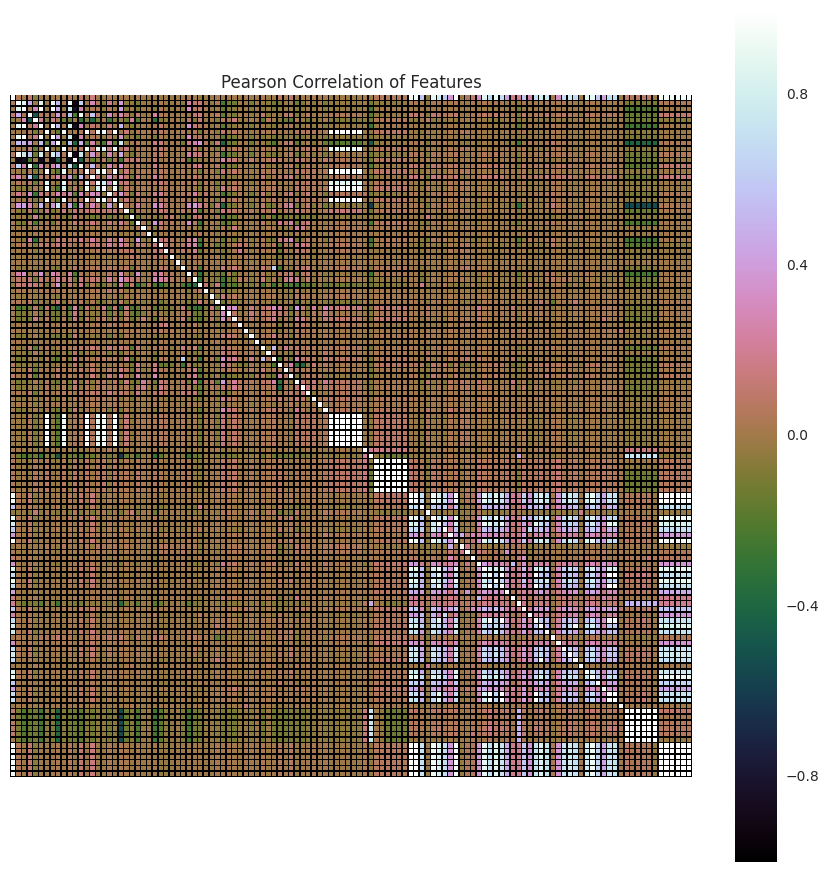

In [16]:
f, ax = plt.subplots(figsize=(11, 11))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=False)
plt.xticks([])
plt.yticks([])
plt.show()

#### VIF Proposed Features

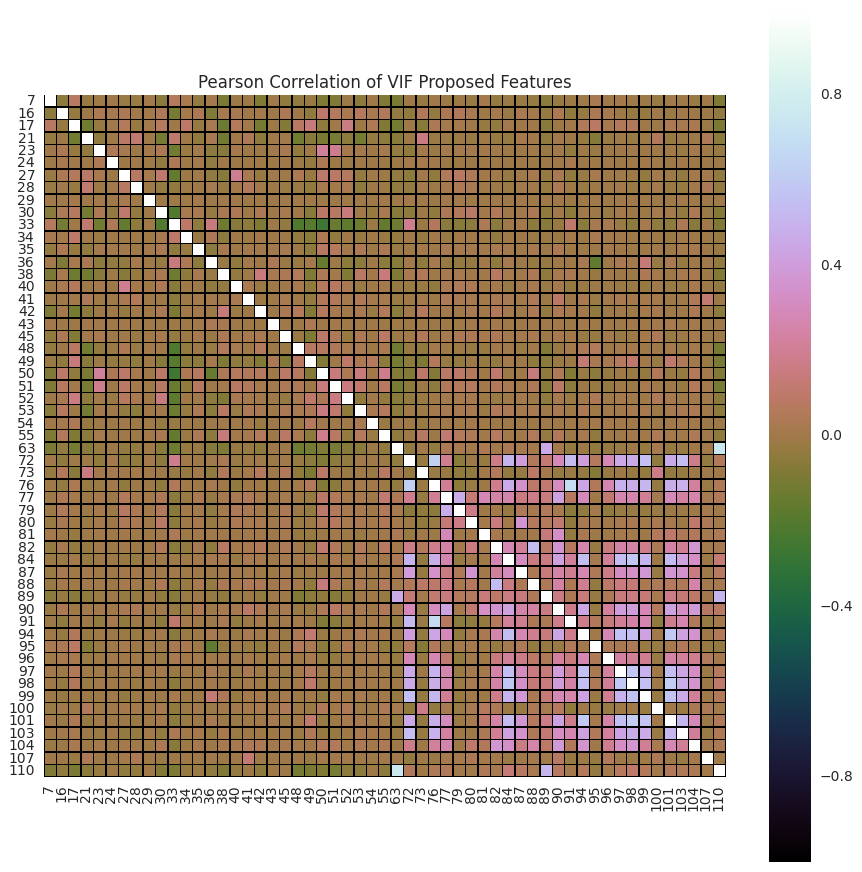

In [101]:
vif_idx = [  7,  16,  17,  21,  23,  24,  27,  28,  29,  30,  33,  34,  35,
             36,  38,  40,  41,  42,  43,  45,  48,  49,  50,  51,  52,  53,
             54,  55,  63,  72,  73,  76,  77,  79,  80,  81,  82,  84,  87,
             88,  89,  90,  91,  94,  95,  96,  97,  98,  99, 100, 101, 103,
            104, 107, 110]
f, ax = plt.subplots(figsize=(11, 11))
plt.title('Pearson Correlation of VIF Proposed Features')
sns.heatmap(data.iloc[:, vif_idx].corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=False)
plt.show()

#### Recursive Feature Elimination ( RFE )
Utilize mean value of annotations instead of hard binary decision values.

In [60]:
lr = LinearRegression(normalize=True)
lr.fit(f_data,Y_mean)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(f_data,Y_mean)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), range(120), order=-1)

Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting

In [78]:
rfe_list = sorted([(k,v) for k, v in ranks['RFE'].iteritems()], key=lambda x: x[1])
rfe_list[:10]

[(18, 0.0),
 (6, 0.01),
 (13, 0.02),
 (9, 0.03),
 (15, 0.03),
 (69, 0.04),
 (16, 0.05),
 (1, 0.06),
 (108, 0.07),
 (77, 0.08)]

#### Linear Model Feature Ranking

In [62]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(f_data, Y_mean)
ranks["LinReg"] = ranking(np.abs(lr.coef_), range(120))

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(f_data, Y_mean)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), range(120))

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(f_data, Y_mean)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), range(120))

/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [71]:
lr_rank = sorted([(k,v) for k,v in ranks['LinReg'].iteritems()], key=lambda x: x[1], reverse=True)
ridge_rank = sorted([(k,v) for k,v in ranks['Ridge'].iteritems()], key=lambda x: x[1], reverse=True)
lasso_rank = sorted([(k,v) for k,v in ranks['Lasso'].iteritems()], key=lambda x: x[1], reverse=True)

In [74]:
print('TOP 10 LINREG RANK')
lr_rank[:10]

TOP 10 LINREG RANK


[(116, 1.0),
 (118, 0.45),
 (114, 0.37),
 (115, 0.37),
 (117, 0.19),
 (119, 0.01),
 (0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0)]

In [69]:
print('TOP 10 LASSO RANK')
lasso_rank[:10]

TOP 10 LASSO RANK


[(9, 1.0),
 (56, 0.77),
 (114, 0.31),
 (6, 0.3),
 (13, 0.23),
 (11, 0.22),
 (18, 0.12),
 (16, 0.09),
 (58, 0.02),
 (59, 0.01)]

In [72]:
print('TOP 10 RIDGE RANK')
ridge_rank[:10]

TOP 10 RIDGE RANK


[(47, 1.0),
 (32, 0.77),
 (26, 0.76),
 (31, 0.62),
 (25, 0.6),
 (38, 0.6),
 (49, 0.51),
 (20, 0.44),
 (84, 0.41),
 (92, 0.41)]

#### Random Forest Feature Ranking

In [96]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(f_data, Y_mean)
ranks["RF"] = ranking(rf.feature_importances_, range(120))

building tree 1 of 50building tree 3 of 50building tree 2 of 50  building tree 6 of 50building tree 7 of 50building tree 8 of 50


building tree 5 of 50building tree 4 of 50




building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50building tree 18 of 50

building tree 19 of 50
building tree 20 of 50
 building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.0s finished


In [97]:
rf_rank = sorted([(k,v) for k,v in ranks['RF'].iteritems()], key=lambda x: x[1], reverse=True)
rf_rank

[(26, 1.0),
 (31, 0.99),
 (20, 0.98),
 (32, 0.98),
 (49, 0.97),
 (33, 0.96),
 (39, 0.96),
 (25, 0.95),
 (38, 0.95),
 (44, 0.95),
 (48, 0.95),
 (63, 0.93),
 (21, 0.92),
 (51, 0.92),
 (47, 0.91),
 (22, 0.89),
 (46, 0.87),
 (50, 0.85),
 (37, 0.81),
 (30, 0.8),
 (52, 0.79),
 (19, 0.78),
 (8, 0.75),
 (42, 0.73),
 (55, 0.73),
 (36, 0.69),
 (53, 0.69),
 (27, 0.67),
 (14, 0.64),
 (28, 0.64),
 (40, 0.61),
 (7, 0.57),
 (62, 0.55),
 (95, 0.55),
 (2, 0.54),
 (34, 0.53),
 (1, 0.52),
 (15, 0.49),
 (23, 0.49),
 (11, 0.44),
 (72, 0.4),
 (9, 0.38),
 (16, 0.36),
 (70, 0.35),
 (41, 0.32),
 (71, 0.32),
 (10, 0.3),
 (35, 0.3),
 (18, 0.22),
 (3, 0.21),
 (6, 0.21),
 (12, 0.2),
 (24, 0.2),
 (13, 0.19),
 (74, 0.19),
 (54, 0.17),
 (64, 0.17),
 (65, 0.17),
 (69, 0.17),
 (66, 0.16),
 (68, 0.16),
 (116, 0.16),
 (117, 0.16),
 (118, 0.16),
 (0, 0.15),
 (67, 0.15),
 (114, 0.15),
 (115, 0.15),
 (45, 0.14),
 (90, 0.14),
 (119, 0.14),
 (76, 0.13),
 (78, 0.13),
 (4, 0.12),
 (91, 0.12),
 (60, 0.11),
 (83, 0.11),
 (56, 0.1

### Generate Feature Rank Dictionary

In [100]:
r = {}
for name in range(119):
    r[name] = round(np.mean([ranks[method][name]for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in range(119):
    print("%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods]))))

	Lasso	LinReg	Mean	RF	RFE	Ridge	rlasso/Stability	Mean
0	0.0	0.0	0.19	0.15	0.59	0.4	0.0	0.19
1	0.0	0.0	0.1	0.52	0.06	0.0	0.0	0.1
2	0.0	0.0	0.25	0.54	0.88	0.08	0.0	0.25
3	0.0	0.0	0.17	0.21	0.77	0.03	0.0	0.17
4	0.0	0.0	0.17	0.12	0.89	0.0	0.0	0.17
5	0.0	0.0	0.16	0.09	0.78	0.09	0.0	0.16
6	0.3	0.0	0.09	0.21	0.01	0.0	0.0	0.09
7	0.0	0.0	0.24	0.57	0.87	0.0	0.0	0.24
8	0.0	0.0	0.15	0.75	0.13	0.0	0.0	0.15
9	1.0	0.0	0.24	0.38	0.03	0.0	0.0	0.24
10	0.0	0.0	0.1	0.3	0.16	0.15	0.0	0.1
11	0.22	0.0	0.24	0.44	0.76	0.02	0.0	0.24
12	0.0	0.0	0.06	0.2	0.15	0.01	0.0	0.06
13	0.23	0.0	0.07	0.19	0.02	0.0	0.0	0.07
14	0.0	0.0	0.14	0.64	0.17	0.01	0.0	0.14
15	0.0	0.0	0.09	0.49	0.03	0.0	0.0	0.09
16	0.09	0.0	0.08	0.36	0.05	0.0	0.0	0.08
17	0.0	0.0	0.05	0.06	0.22	0.01	0.0	0.05
18	0.12	0.0	0.06	0.22	0.0	0.0	0.0	0.06
19	0.0	0.0	0.24	0.78	0.5	0.13	0.0	0.24
20	0.0	0.0	0.34	0.98	0.62	0.44	0.0	0.34
21	0.0	0.0	0.3	0.92	0.67	0.21	0.0	0.3
22	0.0	0.0	0.33	0.89	0.71	0.37	0.0	0.33
23	0.0	0.0	0.27	0.49	0.86	0.25	0.0	0.27
24	0.0	0.0	0.

In [113]:
mean_list = sorted([(k,v) for k, v in ranks['Mean'].iteritems()], key=lambda x: x[1], reverse=True)
top_15 = [i[0] for i in mean_list[:15]]

#### Correlation of Top 15 Feature Ranks Based on Feature Selection Process

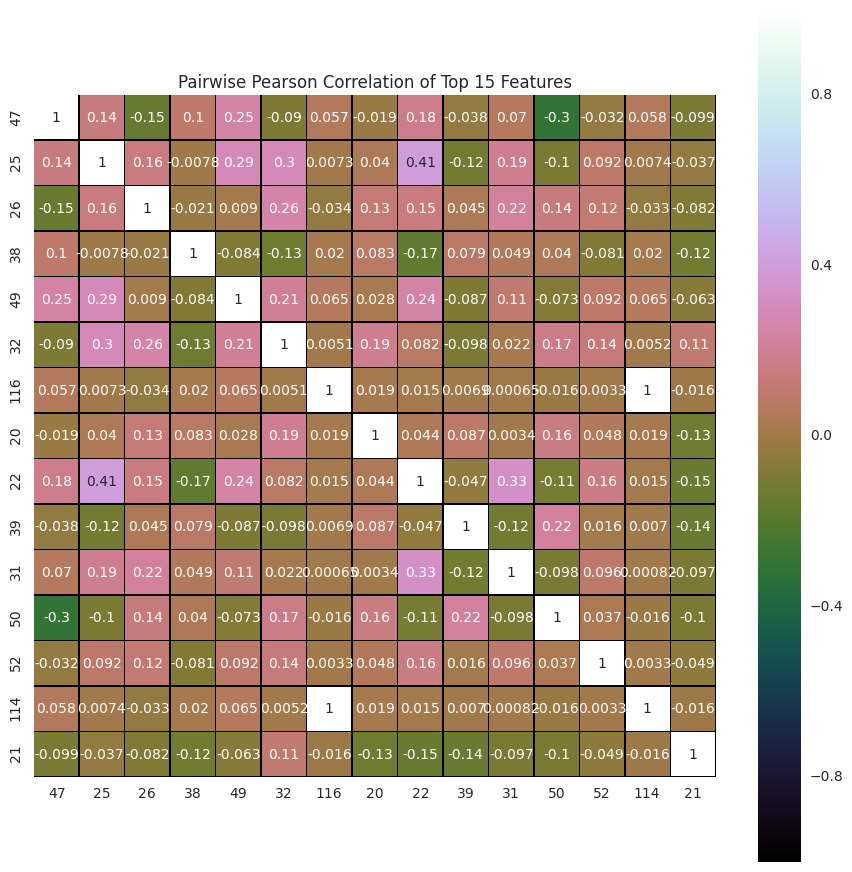

In [117]:
f, ax = plt.subplots(figsize=(11, 11))
plt.title('Pairwise Pearson Correlation of Top 15 Features')
sns.heatmap(data.iloc[:, top_15].corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)
plt.show()